In [2]:
import s3fs
import pyarrow.parquet as pq
import geopandas as gp
import matplotlib.pyplot as plt
import duckdb
import json

In [3]:
plt.style.use('ggplot')
conn = duckdb.connect()

In [4]:
airflow_conns = json.load(open('../connections.json'))
fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url": airflow_conns['aws_s3_conn_id']['host'],
        "aws_access_key_id": airflow_conns['aws_s3_conn_id']['login'],
        "aws_secret_access_key": airflow_conns['aws_s3_conn_id']['password'],
    }
)

In [ ]:
columns = ['adm4_name', 'geometry', 'id']
filters = [('adm4_name', '=', 'Minas Gerais')]
stations = pq.read_table("dutrajardim-fi/tables/stations/osm_adm8.parquet", filesystem=fs, columns=columns, filters=filters)

columns = ['name', 'id']
filters= [('name', '=', 'Minas Gerais')]
relations = pq.read_table("dutrajardim-fi/tables/shapes/osm/relations.parquet/adm=4", filesystem=fs, filters=filters, columns=columns)

filters = [('id', '=', relations.to_pylist()[0]['id'])]
shapes = pq.read_table("dutrajardim-fi/tables/shapes/osm/shapes.parquet/adm=4", filesystem=fs, filters=filters)

filters = [('adm4_name', '=', 'Minas Gerais')]
columns = ['adm4_name', 'station']
ghcn = pq.read_table(fs.glob("dutrajardim-fi/tables/ghcn/osm_adm8.parquet/*/year=2022/*/*"), filesystem=fs, filters=filters, columns=columns)

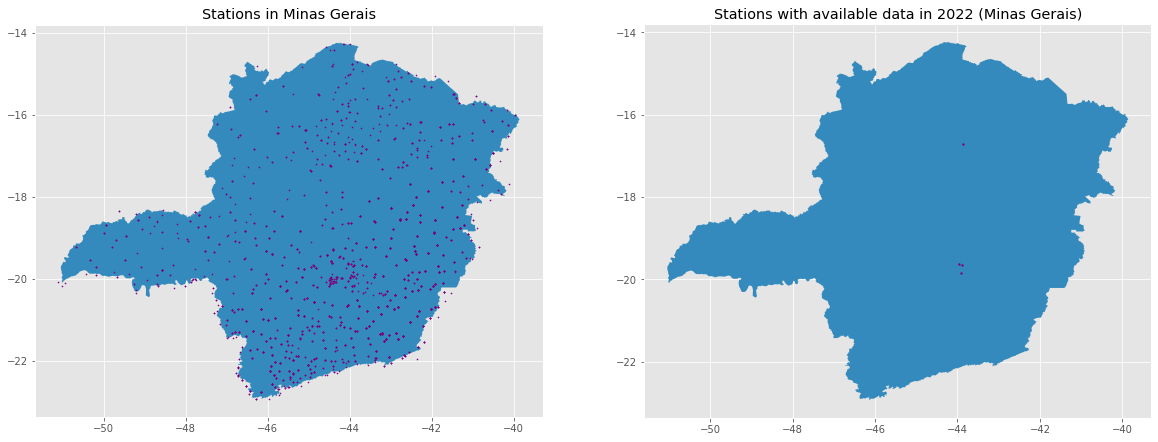

In [37]:
stations_mg = conn.execute("""
SELECT * FROM stations
""").df()

gdf_stations_mg = gp.GeoDataFrame(
    data=stations_mg.copy(),
    geometry=gp.GeoSeries.from_wkt(stations_mg['geometry'])
)

df_shapes = shapes.to_pandas()

gdf_shapes_mg = gp.GeoDataFrame(
    data=df_shapes,
    geometry=gp.GeoSeries.from_wkt(df_shapes['geometry'])
)

stations_mg_2022 = conn.execute("""
SELECT DISTINCT(station), FIRST(stations.geometry) as geometry
FROM ghcn
INNER JOIN stations ON ghcn.station = stations.id
GROUP BY station
""").df()

gdf_stations_mg_2022 = gp.GeoDataFrame(
    data=stations_mg_2022.copy(),
    geometry=gp.GeoSeries.from_wkt(stations_mg_2022['geometry'])
)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

gdf_shapes_mg.plot(ax=ax[0])
gdf_shapes_mg.plot(ax=ax[1])

gdf_stations_mg.plot(ax=ax[0], color='purple', markersize=1.2)
gdf_stations_mg_2022.plot(ax=ax[1], color='purple', markersize=3)

ax[0].set_title("Stations in Minas Gerais")
ax[1].set_title("Stations with available data in 2022 (Minas Gerais)")

fig.savefig(f"../docs/images/charts/BRA_MG/availability_of_ghcn_data/2022_Belo Horizonte.svg") 